# Gas Fraction Plots Using our Lookup Table for Stellar Mass Densities


In [1]:
GAS_FRAC_PATH = "/arc/home/IsaacCheng/coop_f2021/galaxies/gas_fraction/"
%cd "$GAS_FRAC_PATH"

from multiprocessing import Pool
from itertools import repeat
import re

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dill
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
from radial_profile import RadialProfile
# 
GALDIST = 16.5 * u.Mpc  # distance to Virgo cluster centre

/arc/home/IsaacCheng/coop_f2021/galaxies/gas_fraction


In [2]:
ALPHA_CO = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio
I_THRESHOLD = 80  # degree. If inclination >= I_THRESHOLD, means high-i galaxy

GALAXIES = np.array(
    [
        "IC3392",
        # "NGC4189",  # ignored flag map, but bad results
        "NGC4192",
        "NGC4216",  # has unflagged foreground star
        "NGC4222",
        "NGC4254",
        "NGC4294",
        "NGC4298",
        "NGC4299",
        "NGC4302",
        "NGC4321",
        "NGC4330",
        "NGC4351",
        "NGC4380",
        "NGC4383",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4405",
        "NGC4419",
        "NGC4424",
        "NGC4450",
        "NGC4501",
        "NGC4522",
        "NGC4532",
        "NGC4535",
        "NGC4548",
        "NGC4567",
        "NGC4568",
        "NGC4569",
        "NGC4579",
        "NGC4580",
        # "NGC4606",  # flag map too intrusive
        "NGC4607",
        "NGC4651",
        "NGC4654",
        "NGC4689",
        "NGC4694",
    ]
)
INCLINATIONS = np.array(
    [
        68,
        # 42,  # ignored flag map, but bad results
        83,
        90,  # has unflagged foreground star
        90,
        39,
        74,
        52,
        14,
        90,
        32,
        90,
        48,
        61,
        56,
        83,
        83,
        80,
        46,
        74,
        61,
        51,
        65,
        82,
        64,
        48,
        37,
        49,
        70,
        69,
        40,
        46,
        # 69,  # flag map too intrusive
        90,
        53,
        61,
        38,
        62,
    ]
)  # degrees
POSITION_ANGLES = np.array(
    [
        219,
        # 70,  # ignored flag map, but bad results
        333,
        20,  # has unflagged foreground star
        238,
        243,
        151,
        132,
        128,
        356,
        280,
        238,
        251,
        158,
        17,
        271,
        304,
        270,
        18,
        131,
        274,
        170,
        320,
        35,
        159,
        12,
        318,
        251,
        211,
        203,
        273,
        337,
        # 38,  # flag map too intrusive
        2,
        75,
        300,
        341,
        323,
    ]
)  # degrees
HIGH_I_GALAXIES = np.array(
    [
        "NGC4192",
        "NGC4216",
        "NGC4222",
        "NGC4302",
        "NGC4330",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4522",
        "NGC4607",
    ]
)
HIGH_I_HEIGHTS_ARCSEC = np.array(
    [80, 60, 25, 55, 38, 65, 43, 45, 40, 70,]
)  # arcsec, for radial profiles

In [3]:
from radio_beam import Beam

def get_gas_frac_rp(
    galaxy, i, pa, 
    n_annuli=None, snr_cutoff=None,
    avg_function="mean", max_snr_annuli=40,
    min_width=None, bootstrap_errs=True, bootstrap_seed=1234,
    include_bad=None,  # overrides default include_bad
    no_norm=True,  # specifies infile to use
):
    # 
    # Load stellar mass density data
    # 
    galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
    if no_norm:
        galaxy_infile = galpath + f"{galaxy}_regBin_extinctionCorr_9as_ugiz_Sigma-star_noNorm_i_corr.pkl"
    else:
        raise ValueError("You should always use the _noNorm files")
        # galaxy_infile = galpath + f"{galaxy}_regBin_extinctionCorr_9as_ugiz_Sigma-star.pkl"
    with open(galaxy_infile, "rb") as f:
        file = dill.load(f)
        M_density = file ["stellar_mass_density"]
        M_density_err = file["stellar_mass_density_err"]
        file = None  # free memory
    #
    # Load molecular gas density data
    #
    if galaxy == "NGC4321":  # no 9 arcsec data since native is 10 arcsec
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3.1/native/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_round_mom0_unc.fits"
    else:
        Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
        Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"
    Ico_data, gal_header = fits.getdata(Ico_path, header=True)
    Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
    gal_wcs = WCS(gal_header)
    #
    # Get radial profile parameters
    #
    centre = gal_wcs.pixel_to_world(Ico_data.shape[1] / 2, Ico_data.shape[0] / 2)
    if i >= I_THRESHOLD:
        if include_bad is None:
            include_bad = False
        high_i_height = HIGH_I_HEIGHTS_ARCSEC[galaxy == HIGH_I_GALAXIES] * u.arcsec
    else:
        if include_bad is None:
            include_bad = True  # only include NaNs if low-i galaxy
        high_i_height = None
    if n_annuli is None and snr_cutoff is None:
        if galaxy == "NGC4698" or galaxy == "NGC4772":
            snr_cutoff = None
            n_annuli = 5
        else:
            snr_cutoff = 0  # fit until no gas detected
            n_annuli = None
    #
    # Get annulus width in degree (just to store)
    #
    beam = Beam.from_fits_header(gal_header)
    annulus_width_arcsec = np.max([beam.major.to(u.arcsec).value, beam.minor.to(u.arcsec).value])
    # annulus_width = annulus_width * u.arcsec
    # 
    # Mask background
    #
    Ico_mask = (~np.isfinite(Ico_unc)) | (Ico_unc <= 0)
    Ico_data[Ico_mask] = np.nan
    Ico_unc[Ico_mask] = np.nan
    #
    # Convert to gas density (M_sun/pc^2)
    #
    gas_density_i_uncorr = ALPHA_CO / R_21 * Ico_data
    gas_density_unc_i_uncorr = ALPHA_CO / R_21 * Ico_unc
    #
    # Correct for inclination
    #
    gas_density = rpu.correct_for_i(
        gas_density_i_uncorr, i, i_threshold=I_THRESHOLD, i_replacement=I_THRESHOLD
    )
    gas_density_unc = rpu.correct_for_i(
        gas_density_unc_i_uncorr, i, i_threshold=I_THRESHOLD, i_replacement=I_THRESHOLD
    )
    #
    # Convert to gas fraction
    #
    gas_frac, gas_frac_unc = fu.calc_gas_fraction(
        gas_density, M_density, gas_density_unc, M_density_err
    )
    #
    # Make radial profile
    #
    galaxy_rp = RadialProfile(gas_frac, centre, i, pa, noise=gas_frac_unc)
    galaxy_rp = galaxy_rp.calc_radial_profile(
        i_threshold=I_THRESHOLD,
        n_annuli=n_annuli,
        snr_cutoff=snr_cutoff,
        max_snr_annuli=max_snr_annuli,
        min_width=min_width,
        wcs=gal_wcs,
        header=gal_header,
        include_bad=include_bad,
        method="exact",
        func=avg_function,
        is_radio=True,
        high_i_height=high_i_height,
        bootstrap_errs=bootstrap_errs,
        bootstrap_seed=bootstrap_seed,
    )
    return galaxy_rp, centre, annulus_width_arcsec

# Do all NGVS-VERTICO galaxies


In [4]:
# 
# Load VERTICO gas density radial profiles (to get n_annuli)
# 
with open("/arc/home/IsaacCheng/coop_f2021/galaxies/gas_densities/gas_density_i_corr_allVERTICO.pkl", "rb") as f:
    file = dill.load(f)
    vertico_gals = file["galaxies"]
    vertico_inclinations = file["inclinations"]
    vertico_pas = file["position_angles"]
    vertico_rps = file["radial_profiles"]
    file = None  # free memory
n_annulis = []
for g, i, p, rp in zip(vertico_gals, vertico_inclinations, vertico_pas, vertico_rps):
    if g not in GALAXIES:
        continue
    n_annulis.append(len(rp.annuli))
print(len(n_annulis))
print(n_annulis)  # here, n_annulis correspond to the alphabetized GALAXIES (make sure all lists/arrays correspond element-wise!)
print(GALAXIES)

36
[3, 19, 21, 9, 16, 3, 7, 6, 18, 15, 9, 5, 5, 5, 10, 8, 13, 3, 4, 4, 7, 7, 7, 4, 12, 11, 6, 5, 8, 11, 4, 7, 6, 8, 8, 5]
['IC3392' 'NGC4192' 'NGC4216' 'NGC4222' 'NGC4254' 'NGC4294' 'NGC4298'
 'NGC4299' 'NGC4302' 'NGC4321' 'NGC4330' 'NGC4351' 'NGC4380' 'NGC4383'
 'NGC4388' 'NGC4396' 'NGC4402' 'NGC4405' 'NGC4419' 'NGC4424' 'NGC4450'
 'NGC4501' 'NGC4522' 'NGC4532' 'NGC4535' 'NGC4548' 'NGC4567' 'NGC4568'
 'NGC4569' 'NGC4579' 'NGC4580' 'NGC4607' 'NGC4651' 'NGC4654' 'NGC4689'
 'NGC4694']


In [5]:
with Pool(processes=None) as p:
    radial_profiles, centers, annulus_widths_arcsec = zip(
        *p.starmap(
            get_gas_frac_rp, zip(GALAXIES, INCLINATIONS, POSITION_ANGLES, n_annulis)
        )
    )
radial_profiles = list(radial_profiles)
centers = list(centers)
annulus_widths_arcsec = list(annulus_widths_arcsec)
print("Done")




: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNINGWARNING
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
WARNING


: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]




: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]
WARNING

: F

Info: using provided WCS instead of converting header to WCS

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Info: using provided WCS instead of converting header to WCS

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Getting minimum width from radio beam size

Info: using provided WCS instead of converting header to WCS



Getting minimum width from radio beam sizeGetting minimum width from radio beam size



: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58835.533518 from DATE-OBS'. [astropy.wcs.wcs]WARNING
: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58771.720579 from DATE-OBS'. [astropy.wcs.wcs]
: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58786.495183 from DATE-OBS'. [astropy.wcs.wcs]


Min width/beam size (pixels):Info: using provided WCS instead of converting header to WCSMin width/beam size (pixels):Min width/beam size (pixels):   4.50000000024623954.50000000012204


WARNING


4.50000000014364
Getting minimum width from radio beam size


WARNING

Info: using provided WCS instead of converting header to WCS



: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Getting minimum width from radio beam size


: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING

Info: using provided WCS instead of converting header to WCS

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]




WARNING

Getting minimum width from radio beam size

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58807.603859 from DATE-OBS'. [astropy.wcs.wcs]


WARNING

Min width/beam size (pixels):

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Info: using provided WCS instead of converting header to WCS4.50000000020304Min width/beam size (pixels): 

WARNING


Min width/beam size (pixels):Getting minimum width from radio beam size


: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

4.5000000002840395 


4.50000000012024

Info: using provided WCS instead of converting header to WCSMin width/beam size (pixels):

WARNINGWARNINGWARNINGWARNING

Info: using provided WCS instead of converting header to WCS

WARNINGWARNINGWARNINGWARNING

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57613.735997 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57594.978228 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58811.578396 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58910.235509 from DATE-OBS'. [astropy.wcs.wcs]

Getting minimum width from radio beam size

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58858.416048 from DATE-OBS'. [astropy.wcs.wcs]

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57524.101317 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58827.396029 from DATE-OBS'. [astropy.wcs.wcs]

Info: using provided WCS instead of converting header to WCSGetting minimum width from radio beam size

4.50000000014004

Getting minimum width from radio beam sizeInfo: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuliInfo: using provided WCS instead of converting header to WCS



WARNINGWARNINGWARNINGWARNINGWARNING

WARNING

Min width/beam size (pixels):Info: using provided WCS instead of converting header to WCS

WARNING

Min width/beam size (pixels):

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58906.231702 from DATE-OBS'. [astropy.wcs.wcs]WARNING: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58821.370833 from DATE-OBS'. [astropy.wcs.wcs]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58125.369839 from DATE-OBS'. [astropy.wcs.wcs]: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58855.371869 from DATE-OBS'. [astropy.wcs.wcs]

WARNING


Height (pixels):




: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58839.379235 from DATE-OBS'. [astropy.wcs.wcs]
: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

4.50000000016344

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58820.540981 from DATE-OBS'. [astropy.wcs.wcs]

4.50000000011664

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 57729.380956 from DATE-OBS'. [astropy.wcs.wcs]

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58197.199664 from DATE-OBS'. [astropy.wcs.wcs]
: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58832.392244 from DATE-OBS'. [astropy.wcs.wcs]




19.9999999999984


: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]
WARNING

Getting minimum width from radio beam size


: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNINGWARNING



WARNING

Min width/beam size (pixels):

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]
: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNING

4.50000000021924

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58184.283297 from DATE-OBS'. [astropy.wcs.wcs]


: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]WARNINGWARNING




Info: using provided WCS instead of converting header to WCS

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Info: using provided WCS instead of converting header to WCS



Getting minimum width from radio beam sizeInfo: using provided WCS instead of converting header to WCSInfo: using provided WCS instead of converting header to WCSGetting minimum width from radio beam sizeInfo: using provided WCS instead of converting header to WCS


Info: using provided WCS instead of converting header to WCS



WARNING

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Getting minimum width from radio beam size

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Getting minimum width from radio beam size

Info: using provided WCS instead of converting header to WCSInfo: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size


Getting minimum width from radio beam sizeGetting minimum width from radio beam size


WARNING

Info: using provided WCS instead of converting header to WCS
Min width/beam size (pixels):Info: using provided WCS instead of converting header to WCSMin width/beam size (pixels):Min width/beam size (pixels):Info: using provided WCS instead of converting header to WCSInfo: using provided WCS instead of converting header to WCSMin width/beam size (pixels):


WARNING

Info: using provided WCS instead of converting header to WCS
 
   

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]


4.50000000019764Getting minimum width from radio beam size4.50000000015804

WARNING

4.500000000210241Min width/beam size (pixels):Getting minimum width from radio beam size4.5000000004406395


 Getting minimum width from radio beam size


: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58203.170749 from DATE-OBS'. [astropy.wcs.wcs]






Min width/beam size (pixels):

WARNING

Getting minimum width from radio beam sizeInfo: using provided WCS instead of converting header to WCS

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]


Info: using provided WCS instead of converting header to WCSInfo: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli 
Min width/beam size (pixels):
4.50000000015984Info: using provided WCS instead of converting header to WCSGetting minimum width from radio beam size


Getting minimum width from radio beam size Getting minimum width from radio beam size

5.092956068889193Getting minimum width from radio beam size

Getting minimum width from radio beam size

Getting minimum width from radio beam size


4.50000000027684Min width/beam size (pixels):


Min width/beam size (pixels):  Min width/beam size (pixels):Min width/beam size (pixels):4.5000000001472396

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

Min width/beam size (pixels):Min width/beam size (pixels): 

WARNING

 
 
4.50000000017604

: FITSFixedWarning: 'obsfix' made the change 'Observatory coordinates incomplete'. [astropy.wcs.wcs]

4.500000000149044.500000000163444.500000000075239Min width/beam size (pixels):Min width/beam size (pixels):

Height (pixels):
Min width/beam size (pixels):Min width/beam size (pixels):
  
 Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuliInfo: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli34.9999999999972Info: using provided WCS instead of converting header to WCS 4.50000000009684
 


Info: using provided WCS instead of converting header to WCS
4.500000000190444.49773120432584

Getting minimum width from radio beam sizeInfo: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Height (pixels):
Min width/beam size (pixels):4.50000000020844Height (pixels):
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli   4.5000000002246427.4999999999978
Info: using provided WCS instead of co

WARNING

29.999999999997602

WARNING

Height (pixels):

: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]

Min width/beam size (pixels):


: FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0) [astropy.wcs.wcs]

32.4999999999974  

4.50000000016704Min width/beam size (pixels):
4.50000000012564Height (pixels):Info: using provided WCS instead of converting header to WCS
  
4.500000000179639Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli

Info: Inclination greater than i_threshold. Fitting rectangles along major axis instead of ellipses/annuli
12.499999999999002
Height (pixels):

WARNING

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58837.456786 from DATE-OBS'. [astropy.wcs.wcs]

21.49999999999828

Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam sizeHeight (pixels):
 Getting minimum width from radio beam size22.499999999998202


Min width/beam size (pixels): 4.50000000021924
Min width/beam size (pixels): 4.5000000001616405

Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size


Min width/beam size (pixels):

: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58119.389391 from DATE-OBS'. [astropy.wcs.wcs]

4.50000000023364
Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size
Min width/beam size (pixels): 

4.50000000013464


Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000018684
Done


In [6]:
print(np.shape(radial_profiles))
print(np.shape(centers))
print(np.shape(annulus_widths_arcsec))
print(type(annulus_widths_arcsec))
print(annulus_widths_arcsec)

(36,)
(36,)
(36,)
<class 'list'>
[9.000000000241199, 8.9954624086524, 9.000000000381599, 9.0000000004176, 9.00000000045, 9.0000000004068, 9.000000000396001, 9.000000000234001, 9.0000000001512, 10.185912137779201, 9.000000000327601, 9.0000000005688, 9.000000000287999, 9.0000000004212, 9.0000000002952, 9.000000000252, 9.000000000378, 9.0000000002448, 9.000000000352799, 9.0000000004932, 9.000000000554401, 9.000000000316799, 9.000000000280801, 9.0000000001944, 9.000000000298801, 9.00000000036, 9.0000000003204, 9.0000000004392, 9.000000000324, 9.000000000334799, 9.000000000327601, 9.000000000881998, 9.0000000004392, 9.000000000374401, 9.000000000467999, 9.00000000027]


In [7]:
gas_fraction_outfile = GAS_FRAC_PATH + "gas_fraction_i_corr_NGVS-VERTICO_noNorm.pkl"
with open(gas_fraction_outfile, "wb") as f:
    dill.dump(
        {
            "galaxies": GALAXIES,
            "inclinations": INCLINATIONS,
            "position_angles": POSITION_ANGLES,
            "radial_profiles": radial_profiles,
            "centers": centers,
            "annulus_widths_arcsec": annulus_widths_arcsec,
            "n_annulis": n_annulis,
        },
        f
    )
print("Pickled", gas_fraction_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/gas_fraction/gas_fraction_i_corr_NGVS-VERTICO_noNorm.pkl


# Only plots of NGC 4380 (for now)


In [4]:
gal_to_plot = "NGC4380"
gal_idx = GALAXIES == gal_to_plot
inclination = INCLINATIONS[gal_idx][0]
position_angle = POSITION_ANGLES[gal_idx][0]
average_function = "mean"

gal_rp, gal_centre, _ = get_gas_frac_rp(
    gal_to_plot, inclination, position_angle, n_annuli=4, avg_function=average_function,
)
gal_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000  # assume square pixels

Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000014364


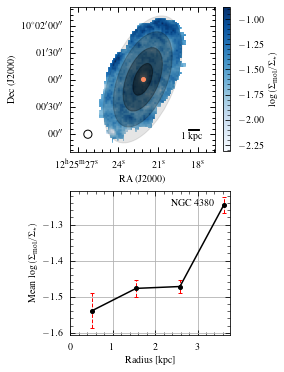

In [6]:
# 
# Plot
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
#
# Plot data
#
# img1 = ax1.imshow(gal_rp.data, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
img1 = ax1.imshow(gal_rp.data, cmap="Blues")
cbar1 = fig.colorbar(img1, fraction=0.045)
cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
# Mark centre
ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C1", markersize=4)
# Add annuli
pu.add_annuli_RadialProfile(ax1, gal_rp, alpha_coeff=0.4)
# Add scalebar
pu.add_scalebar(ax1, gal_wcs, dist=GALDIST)
pu.add_scalebeam(ax1, gal_rp.rp_options["header"])
ax1.set_xlim(0, gal_rp.data.shape[1])
ax1.set_ylim(0, gal_rp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=gal_rp.radii * px_to_kpc,
    y=gal_rp.avg_data,
    yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if inclination >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    gal_rp.rp_options["func"].capitalize()
    + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$"
)
ax2.set_xlim(left=0)
pu.set_aspect(ax2, 0.9, logx=False, logy=False)
#
fig.tight_layout(pad=3.5)
# fig.savefig(GAS_FRAC_PATH + f"{gal_to_plot}_gas_fraction_radProf_4annuli_i_corr.pdf")
plt.show()

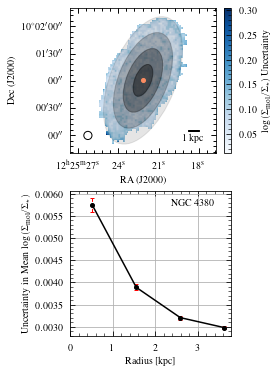

In [8]:
# 
# Plot uncertainty
#
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
#
# Plot data
#
# img1 = ax1.imshow(gal_rp.noise, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
img1 = ax1.imshow(gal_rp.noise, cmap="Blues")
cbar1 = fig.colorbar(img1, fraction=0.045)
cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$ Uncertainty")
# Mark centre
ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C1", markersize=4)
# Add annuli
pu.add_annuli_RadialProfile(ax1, gal_rp, alpha_coeff=0.4)
# Add scalebar
pu.add_scalebar(ax1, gal_wcs, dist=GALDIST)
pu.add_scalebeam(ax1, gal_rp.rp_options["header"])
ax1.set_xlim(0, gal_rp.data.shape[1])
ax1.set_ylim(0, gal_rp.data.shape[0])
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
ax1.set_aspect("equal")
#
ax2 = fig.add_subplot(2, 1, 2)
ebar2 = ax2.errorbar(
    x=gal_rp.radii * px_to_kpc,
    y=gal_rp.avg_noise,
    yerr=gal_rp.avg_noise_err,  # uncertainty in the mean/median from bootstrapping
    fmt="-o",
    markersize=4,
    color="k",
    ecolor="r",
    elinewidth=1,
    capsize=2,
)
ebar2[-1][0].set_linestyle("--")
# 
# Add name of galaxy
# 
high_i_str = "*" if inclination >= I_THRESHOLD else ""
ax2.text(
    0.9,
    0.9,
    re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
    c="k",
    ha="right",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Radius [kpc]")
ax2.set_ylabel(
    "Uncertainty in "
    + gal_rp.rp_options["func"].capitalize()
    + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$"
)
ax2.set_xlim(left=0)
pu.set_aspect(ax2, 0.9, logx=False, logy=False)
#
fig.tight_layout(pad=3.5)
# fig.savefig(GAS_FRAC_PATH + f"{gal_to_plot}_gas_fraction_unc_radProf_4annuli_i_corr.pdf")
plt.show()

# Version for beamer slides


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


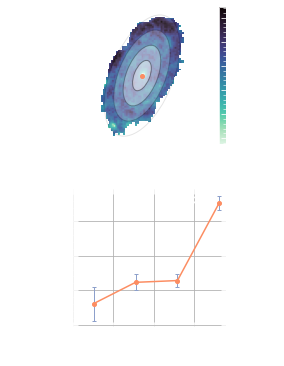

In [10]:
# 
# Plot data
#
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
        #
        # Plot data
        #
        # img1 = ax1.imshow(gal_rp.data, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
        img1 = ax1.imshow(gal_rp.data, cmap=sns.color_palette("mako_r", as_cmap=True))
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
        # Mark centre
        ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C1", markersize=4)
        # Add annuli
        pu.add_annuli_RadialProfile(
            ax1, gal_rp, alpha_coeff=0.4,
            ls="-", edgecolor="k", fc="w", lw=1, zorder=2
        )
        # Add scalebar
        pu.add_scalebar(ax1, gal_wcs, dist=GALDIST, color="w")
        pu.add_scalebeam(ax1, gal_rp.rp_options["header"], ec="w")
        ax1.set_xlim(0, gal_rp.data.shape[1])
        ax1.set_ylim(0, gal_rp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        ebar2 = ax2.errorbar(
            x=gal_rp.radii * px_to_kpc,
            y=gal_rp.avg_data,
            yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
            fmt="-o",
            markersize=4,
            color="C1",
            ecolor="C2",
            elinewidth=1,
            capsize=2,
        )
        # ebar2[-1][0].set_linestyle("--")
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if inclination >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            gal_rp.rp_options["func"].capitalize()
            + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$"
        )
        ax2.set_xlim(left=0)
        pu.set_aspect(ax2, 0.9, logx=False, logy=False)
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(GAS_FRAC_PATH + f"{gal_to_plot}_gas_fraction_radProf_4annuli_beamer_i_corr.pdf")
        plt.show()

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


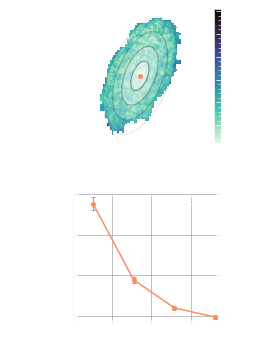

In [11]:
# 
# Plot uncertainty
#
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
        #
        # Plot data
        #
        # img1 = ax1.imshow(gal_rp.noise, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
        img1 = ax1.imshow(gal_rp.noise, cmap=sns.color_palette("mako_r", as_cmap=True))
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$ Uncertainty")
        # Mark centre
        ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C1", markersize=4)
        # Add annuli
        pu.add_annuli_RadialProfile(
            ax1, gal_rp, alpha_coeff=0.4,
            ls="-", edgecolor="k", fc="w", lw=1, zorder=2
        )
        # Add scalebar
        pu.add_scalebar(ax1, gal_wcs, dist=GALDIST, color="w")
        pu.add_scalebeam(ax1, gal_rp.rp_options["header"], ec="w")
        ax1.set_xlim(0, gal_rp.noise.shape[1])
        ax1.set_ylim(0, gal_rp.noise.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        ebar2 = ax2.errorbar(
            x=gal_rp.radii * px_to_kpc,
            y=gal_rp.avg_noise,
            yerr=gal_rp.avg_noise_err,  # uncertainty in the mean/median from bootstrapping
            fmt="-o",
            markersize=4,
            color="C1",
            ecolor="C2",
            elinewidth=1,
            capsize=2,
        )
        # ebar2[-1][0].set_linestyle("--")
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if inclination >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            "Uncertainty in "
            + gal_rp.rp_options["func"].capitalize()
            + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$"
        )
        ax2.set_xlim(left=0)
        pu.set_aspect(ax2, 0.9, logx=False, logy=False)
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(GAS_FRAC_PATH + f"{gal_to_plot}_gas_fraction_unc_radProf_4annuli_beamer_i_corr.pdf")
        plt.show()

In [12]:
# Directional radial profile. Do not include bad just to emphasize difference
gal_to_plot = "NGC4380"
gal_idx = GALAXIES == gal_to_plot
inclination = INCLINATIONS[gal_idx][0]
position_angle = POSITION_ANGLES[gal_idx][0]
average_function = "mean"

gal_rp, gal_centre, _ = get_gas_frac_rp(
    gal_to_plot, inclination, position_angle, n_annuli=4, avg_function=average_function, include_bad=False
)
gal_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000  # assume square pixels
gal_drp = gal_rp.directional_radial_profile(
    angle=None,  # take direction to be along galaxy's major axis
    bootstrap_errs=True,
    bootstrap_seed=1234,
    results_to_1d=True,  # easier to plot radial profile this way
)

Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000014364
Info: using provided WCS instead of converting header to WCS


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


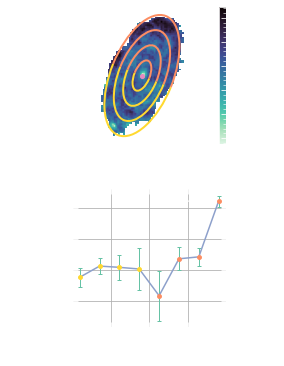

In [13]:
from matplotlib.patches import Arc
# 
# Plot DIRECTIONAL PROFILE data
#
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
        positive_color = "C1"
        negative_color = "C5"
        #
        # Plot data
        #
        # img1 = ax1.imshow(gal_rp.data, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
        img1 = ax1.imshow(gal_drp.data, cmap=sns.color_palette("mako_r", as_cmap=True))
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
        # Mark centre
        ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C3", markersize=4)
        # Add annuli
        # pu.add_annuli_RadialProfile(
        #     ax1, gal_rp, alpha_coeff=0.4,
        #     ls="-", edgecolor="k", fc="w", lw=1, zorder=2
        # )
        # Add annuli from outer to inner
        annuli = np.hstack((gal_drp.annuli[::-1], gal_drp.annuli))
        for num, annulus in enumerate(annuli):
            try:
                # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
                height = annulus.b_out
                width = annulus.a_out
            except AttributeError:
                # EllipticalAperture attributes. N.B. height and width are switched from "normal"
                height = annulus.b
                width = annulus.a
            if num >= len(annuli) / 2:
                # Positive radii annuli
                edgecolor = positive_color
                arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
            else:
                # Negative radii annuli
                edgecolor = negative_color
                arcangle = np.rad2deg(annulus.theta) % 360.0
            arc = Arc(
                xy=annulus.positions,
                width=width * 2,  # full major/minor axis
                height=height * 2,  # full major/minor axis
                angle=arcangle,
                theta1=-90,
                theta2=90,
                ls="-",
                edgecolor=edgecolor,
                alpha=1,
                lw=2,
                zorder=2,
            )
            ax1.add_patch(arc)
        # Add scalebar
        pu.add_scalebar(ax1, gal_wcs, dist=GALDIST, color="w")
        pu.add_scalebeam(ax1, gal_drp.rp_options["header"], ec="w")
        ax1.set_xlim(0, gal_drp.data.shape[1])
        ax1.set_ylim(0, gal_drp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        radii = gal_drp.drp_results["radii"]
        # Plot negative radii data
        ax2.scatter(
            x=radii[radii < 0] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"][radii < 0],
            c=negative_color,
            s=15,
            zorder=3,
        )
        # Plot positive radii data
        ax2.scatter(
            x=radii[radii > 0] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"][radii > 0],
            c=positive_color,
            s=15,
            zorder=3,
        )
        # Plot errorbars
        ebar2 = ax2.errorbar(
            x=gal_drp.drp_results["radii"] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"],
            yerr=gal_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
            fmt="-",
            color="C2",
            ecolor="C0",
            elinewidth=1,
            capsize=2,
        )
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if inclination >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            gal_rp.rp_options["func"].capitalize()
            + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$"
        )
        pu.set_aspect(ax2, 0.9, logx=False, logy=False)
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(GAS_FRAC_PATH + f"{gal_to_plot}_gas_fraction_directionalRadProf_4annuli_noNorm_i_corr_beamer.pdf")
        plt.show()

## Plots of NGC 4567 & NGC 4568 (Butterfly Galaxies) and NGC 4294


In [25]:
gal_to_plot = "NGC4568"
gal_idx = GALAXIES == gal_to_plot
inclination = INCLINATIONS[gal_idx][0]
position_angle = POSITION_ANGLES[gal_idx][0]
average_function = "mean"

gal_rp, gal_centre, _ = get_gas_frac_rp(
    gal_to_plot, inclination, position_angle, n_annuli=4, avg_function=average_function,
    include_bad=False
)
gal_wcs = gal_rp.rp_options["wcs"]
px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000  # assume square pixels

Info: using provided WCS instead of converting header to WCS
Getting minimum width from radio beam size
Min width/beam size (pixels): 4.50000000021924


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


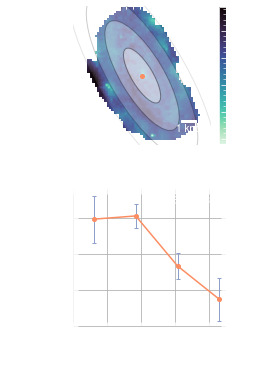

In [29]:
# 
# Plot data
#
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
        #
        # Plot data
        #
        # img1 = ax1.imshow(gal_rp.data, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
        img1 = ax1.imshow(gal_rp.data, cmap=sns.color_palette("mako_r", as_cmap=True))
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
        # Mark centre
        ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C1", markersize=4)
        # Add annuli
        pu.add_annuli_RadialProfile(
            ax1, gal_rp, alpha_coeff=0.4,
            ls="-", edgecolor="k", fc="w", lw=1, zorder=2
        )
        # Add scalebar
        pu.add_scalebar(ax1, gal_wcs, dist=GALDIST, color="w")
        pu.add_scalebeam(ax1, gal_rp.rp_options["header"], ec="w")
        ax1.set_xlim(0, gal_rp.data.shape[1])
        ax1.set_ylim(0, gal_rp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        ebar2 = ax2.errorbar(
            x=gal_rp.radii * px_to_kpc,
            y=gal_rp.avg_data,
            yerr=gal_rp.avg_data_err,  # uncertainty in the mean/median from bootstrapping
            fmt="-o",
            markersize=4,
            color="C1",
            ecolor="C2",
            elinewidth=1,
            capsize=2,
        )
        # ebar2[-1][0].set_linestyle("--")
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if inclination >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            gal_rp.rp_options["func"].capitalize()
            + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$"
        )
        ax2.set_xlim(left=0)
        # ax2.set_xticks(np.arange(0, 4))
        pu.set_aspect(ax2, 0.9, logx=False, logy=False)
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(GAS_FRAC_PATH + f"{gal_to_plot}_gas_fraction_radProf_4annuli_noIncludeBad_i_corr_beamer.pdf")
        plt.show()

In [16]:
gal_drp = gal_rp.directional_radial_profile(
    angle=None,  # take direction to be along galaxy's major axis
    bootstrap_errs=True,
    bootstrap_seed=1234,
    results_to_1d=True,  # easier to plot radial profile this way
)

Info: using provided WCS instead of converting header to WCS


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


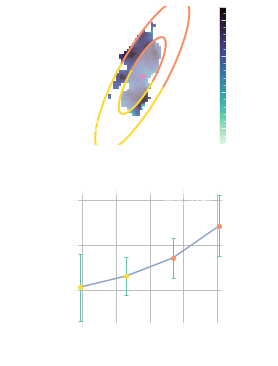

In [18]:
from matplotlib.patches import Arc
# 
# Plot DIRECTIONAL PROFILE data
#
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    with plt.rc_context({"font.size" : 10}):  # temporaily decrease fontsizes
        fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
        ax1 = fig.add_subplot(2, 1, 1, projection=gal_wcs)
        positive_color = "C1"
        negative_color = "C5"
        #
        # Plot data
        #
        # img1 = ax1.imshow(gal_rp.data, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
        img1 = ax1.imshow(gal_drp.data, cmap=sns.color_palette("mako_r", as_cmap=True))
        cbar1 = fig.colorbar(img1, fraction=0.045)
        cbar1.set_label(r"$\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$")
        # Mark centre
        ax1.plot(*gal_wcs.world_to_pixel(gal_centre), marker="o", color="C3", markersize=4)
        # Add annuli
        pu.add_annuli_RadialProfile(
            ax1, gal_rp, alpha_coeff=0.4,
            ls="-", edgecolor="k", fc="w", lw=1, zorder=2
        )
        # Add annuli from outer to inner
        annuli = np.hstack((gal_drp.annuli[::-1], gal_drp.annuli))
        for num, annulus in enumerate(annuli):
            try:
                # EllipticalAnnulus attributes. N.B. height and width are switched from "normal"
                height = annulus.b_out
                width = annulus.a_out
            except AttributeError:
                # EllipticalAperture attributes. N.B. height and width are switched from "normal"
                height = annulus.b
                width = annulus.a
            if num >= len(annuli) / 2:
                # Positive radii annuli
                edgecolor = positive_color
                arcangle = (np.rad2deg(annulus.theta) + 180) % 360.0
            else:
                # Negative radii annuli
                edgecolor = negative_color
                arcangle = np.rad2deg(annulus.theta) % 360.0
            arc = Arc(
                xy=annulus.positions,
                width=width * 2,  # full major/minor axis
                height=height * 2,  # full major/minor axis
                angle=arcangle,
                theta1=-90,
                theta2=90,
                ls="-",
                edgecolor=edgecolor,
                alpha=1,
                lw=2,
                zorder=2,
            )
            ax1.add_patch(arc)
        # Add scalebar
        pu.add_scalebar(ax1, gal_wcs, dist=GALDIST, color="w")
        pu.add_scalebeam(ax1, gal_drp.rp_options["header"], ec="w")
        ax1.set_xlim(0, gal_drp.data.shape[1])
        ax1.set_ylim(0, gal_drp.data.shape[0])
        ax1.set_xlabel("RA (J2000)")
        ax1.set_ylabel("Dec (J2000)")
        ax1.grid(False)
        ax1.set_aspect("equal")
        #
        ax2 = fig.add_subplot(2, 1, 2)
        radii = gal_drp.drp_results["radii"]
        # Plot negative radii data
        ax2.scatter(
            x=radii[radii < 0] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"][radii < 0],
            c=negative_color,
            s=15,
            zorder=3,
        )
        # Plot positive radii data
        ax2.scatter(
            x=radii[radii > 0] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"][radii > 0],
            c=positive_color,
            s=15,
            zorder=3,
        )
        # Plot errorbars
        ebar2 = ax2.errorbar(
            x=gal_drp.drp_results["radii"] * px_to_kpc,
            y=gal_drp.drp_results["avg_data"],
            yerr=gal_drp.drp_results["avg_data_err"],  # uncertainty from bootstrapping
            fmt="-",
            color="C2",
            ecolor="C0",
            elinewidth=1,
            capsize=2,
        )
        # 
        # Add name of galaxy
        # 
        high_i_str = "*" if inclination >= I_THRESHOLD else ""
        ax2.text(
            0.9,
            0.9,
            re.sub(r"(\d+)", " \\1", gal_to_plot) + high_i_str,
            c="w",
            ha="right",
            transform=ax2.transAxes,
        )
        ax2.set_xlabel("Radius [kpc]")
        ax2.set_ylabel(
            gal_rp.rp_options["func"].capitalize()
            + r" $\rm \log\left(\Sigma_{mol} / \rm \Sigma_{\star}\right)$"
        )
        pu.set_aspect(ax2, 0.9, logx=False, logy=False)
        #
        fig.tight_layout(pad=3.5)
        # fig.savefig(GAS_FRAC_PATH + f"{gal_to_plot}_gas_fraction_directionalRadProf_4annuli_noIncludeBad_i_corr_beamer.pdf")
        plt.show()

# Gas Fraction Mosaic


In [4]:
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
NGVS_DECR_MEAN_M_DENSITY_IDX = np.array(
    [
        29, 18, 21, 30, 27, 26, 28, 0, 17, 35, 25, 9, 12, 34, 32, 16, 14, 24, 4, 20, 11, 33, 19, 6, 7, 23, 2, 5, 22, 3, 1, 8, 13, 10, 31, 15,
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
NGVS_DECR_MEDIAN_M_DENSITY_IDX = np.array(
    [
        30, 29, 21, 26, 0, 17, 18, 27, 35, 9, 34, 12, 25, 28, 32, 11, 24, 19, 20, 14, 4, 16, 33, 7, 6, 5, 13, 22, 10, 3, 23, 2, 8, 15, 1, 31
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination

In [5]:
# 
# Load data
# 
gas_fraction_outfile = GAS_FRAC_PATH + "gas_fraction_i_corr_NGVS-VERTICO_noNorm.pkl"
with open(gas_fraction_outfile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    radial_profiles = file["radial_profiles"]
    annulus_widths_arcsec = file["annulus_widths_arcsec"]
    file = None  # free memory
avg_function = radial_profiles[0].rp_options["func"]
# 
# Calculate radii of annuli in kpc
# 
radius_kpc = []
for galname in galaxies:
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    gal_wcs = WCS(radial_profiles[galidx].rp_options["header"])
    px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000
    radius_kpc.append(radial_profiles[galidx].radii * px_to_kpc)

i_threshold = 80  # degree
galaxies_to_plot = galaxies

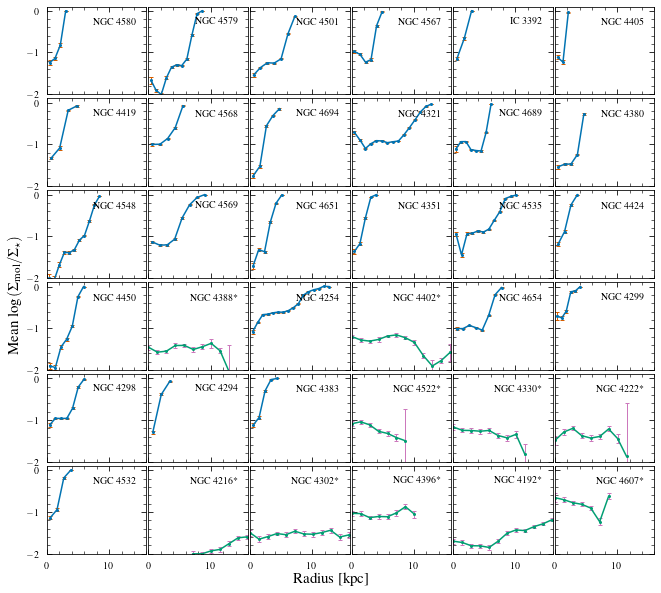

In [16]:
# MOSAIC OF GAS FRACTION DATA

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 8), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten(), galaxies_to_plot[NGVS_DECR_MEDIAN_M_DENSITY_IDX], inclinations[NGVS_DECR_MEDIAN_M_DENSITY_IDX]):
    is_high_i = i >= i_threshold
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=radius_kpc[galidx],
        y=radial_profiles[galidx].avg_data,
        yerr=radial_profiles[galidx].avg_data_err,
        fmt="-o",
        markersize=2,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    # ax.set_ylim(-1.6, 1.5)  # if did not use _noNorm file
    ax.set_ylim(-2, 0.1)  # if used _noNorm file
    ax.set_xlim(0, 16)
    pu.set_aspect(ax, 0.88, logx=False, logy=False)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)

fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"{avg_function.capitalize()} " + r"$\log\left(\Sigma_{\rm mol} / \Sigma_\star\right)$",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
# fig.tight_layout(pad=0)
plt.subplots_adjust(left=0.06, right=1.0, bottom=0.05, top=1.0, wspace=0.005, hspace=0.05)
# fig.savefig(GAS_FRAC_PATH + "gas_fraction_i_corr_NGVS-VERTICO_DecrMedianSigmaStar_noNorm.pdf")
plt.show()

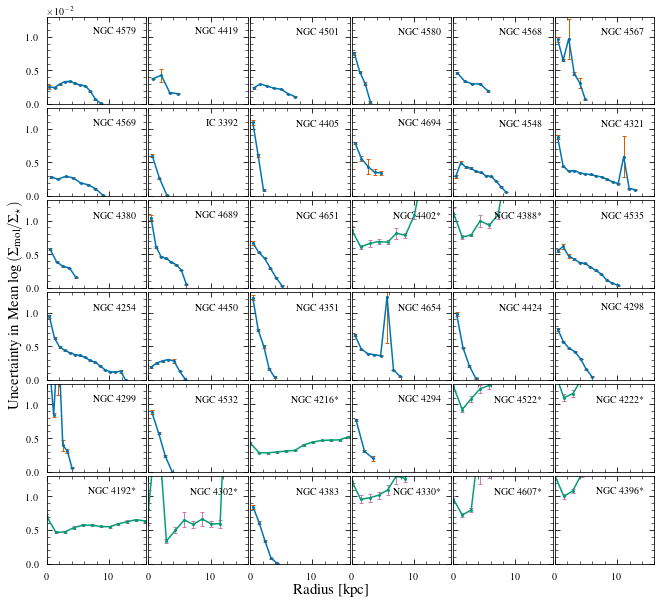

In [15]:
# MOSAIC OF GAS FRACTION UNCERTAINTIES

subplot_num = 0
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 8), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten(), galaxies_to_plot[NGVS_DECR_MEAN_M_DENSITY_IDX], inclinations[NGVS_DECR_MEAN_M_DENSITY_IDX]):
    is_high_i = i >= i_threshold
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=radius_kpc[galidx],
        y=radial_profiles[galidx].avg_noise,
        yerr=radial_profiles[galidx].avg_noise_err,
        fmt="-o",
        markersize=2,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    ax.set_ylim(0, 0.013)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    if subplot_num != 0:
        ax.yaxis.get_offset_text().set_visible(False)  # hide exponent except for rop left plot
    ax.set_xlim(0, 16)
    pu.set_aspect(ax, 0.88, logx=False, logy=False)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)
    subplot_num += 1

fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"Uncertainty in {avg_function.capitalize()} " + r"$\log\left(\Sigma_{\rm mol} / \Sigma_\star\right)$",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
# fig.tight_layout(pad=0)
plt.subplots_adjust(left=0.06, right=1.0, bottom=0.05, top=1.0, wspace=0.005, hspace=0.05)
# fig.savefig(GAS_FRAC_PATH + "gas_fraction_unc_i_corr_NGVS-VERTICO_DecrMeanSigmaStar_noNorm.pdf")
plt.show()

# Version for beamer slides


/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


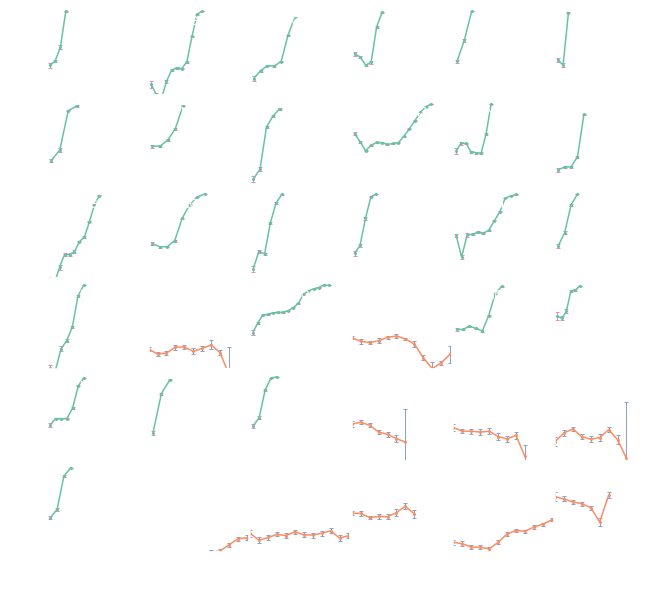

In [22]:
# MOSAIC OF GAS FRACTION DATA
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 8), sharex=True, sharey=True)
    for ax, galname, i in zip(axs.flatten(), galaxies_to_plot[NGVS_DECR_MEDIAN_M_DENSITY_IDX], inclinations[NGVS_DECR_MEDIAN_M_DENSITY_IDX]):
        is_high_i = i >= i_threshold
        galidx = np.where(galaxies == galname)[0]
        if galidx.size != 1:
            raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
        galidx = galidx[0]
        if is_high_i:
            tmp_color = sns.color_palette("Set2")[1]
            tmp_ecolor = sns.color_palette("Set2")[2]
        else:
            tmp_color = sns.color_palette("Set2")[0]
            tmp_ecolor = sns.color_palette("Set2")[3]
        ebar = ax.errorbar(
            x=radius_kpc[galidx],
            y=radial_profiles[galidx].avg_data,
            yerr=radial_profiles[galidx].avg_data_err,
            fmt="-o",
            markersize=2,
            color=tmp_color,
            ecolor=tmp_ecolor,
            elinewidth=1,
            capsize=2,
        )
        # ax.set_ylim(-1.6, 1.5)  # if did not use _noNorm file
        ax.set_ylim(-1.9, 0.1)  # if used _noNorm file
        ax.set_xlim(0, 16)
        pu.set_aspect(ax, 0.88, logx=False, logy=False)
        # Galaxy name in top right corner + add space between letters and numbers in galname
        high_i_str = "*" if is_high_i else ""
        ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="w", ha="right", transform=ax.transAxes)
        ax.grid(False)

    fig.text(0.5, 0.0, "Radius [kpc]", ha="center", color="w", fontsize=15)
    fig.text(
        0.0,
        0.5,
        f"{avg_function.capitalize()} " + r"$\log\left(\Sigma_{\rm mol} / \Sigma_\star\right)$",
        va="center",
        rotation="vertical",
        fontsize=15,
        color="w",
    )
    #
    plt.subplots_adjust(left=0.06, right=1.0, bottom=0.055, top=1.0, wspace=0.005, hspace=0.047)
    # fig.savefig(GAS_FRAC_PATH + "gas_fraction_i_corr_NGVS-VERTICO_DecrMedianSigmaStar_noNorm_beamer.pdf")
    plt.show()

/opt/conda/lib/python3.8/contextlib.py:113: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  return next(self.gen)


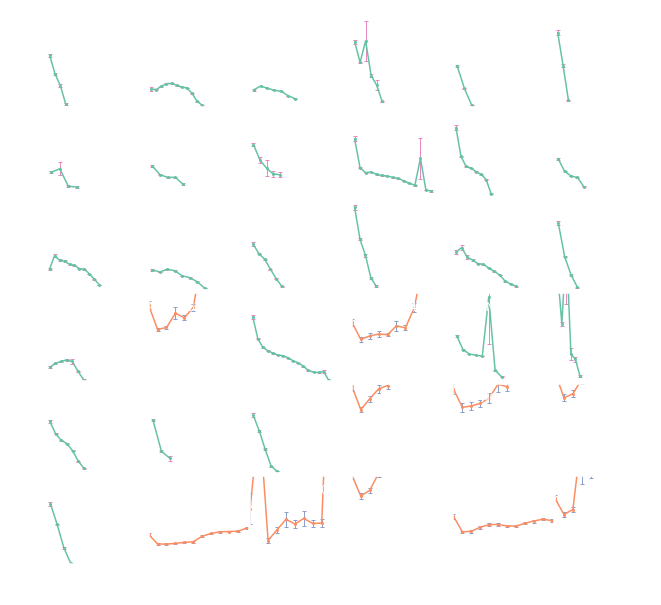

In [25]:
# MOSAIC OF GAS FRACTION UNCERTAINTIES

subplot_num = 0
with plt.style.context("/arc/home/IsaacCheng/coop_f2021/stylesheets/beamer.mplstyle"):
    fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9, 8), sharex=True, sharey=True)
    for ax, galname, i in zip(axs.flatten(), galaxies_to_plot[NGVS_DECR_MEDIAN_M_DENSITY_IDX], inclinations[NGVS_DECR_MEDIAN_M_DENSITY_IDX]):
        is_high_i = i >= i_threshold
        galidx = np.where(galaxies == galname)[0]
        if galidx.size != 1:
            raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
        galidx = galidx[0]
        if is_high_i:
            tmp_color = sns.color_palette("Set2")[1]
            tmp_ecolor = sns.color_palette("Set2")[2]
        else:
            tmp_color = sns.color_palette("Set2")[0]
            tmp_ecolor = sns.color_palette("Set2")[3]
        ebar = ax.errorbar(
            x=radius_kpc[galidx],
            y=radial_profiles[galidx].avg_noise,
            yerr=radial_profiles[galidx].avg_noise_err,
            fmt="-o",
            markersize=2,
            color=tmp_color,
            ecolor=tmp_ecolor,
            elinewidth=1,
            capsize=2,
        )
        ax.set_ylim(0, 0.013)
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        if subplot_num != 0:
            ax.yaxis.get_offset_text().set_visible(False)  # hide exponent except for rop left plot
        ax.set_xlim(0, 16)
        pu.set_aspect(ax, 0.88, logx=False, logy=False)
        # Galaxy name in top right corner + add space between letters and numbers in galname
        high_i_str = "*" if is_high_i else ""
        ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="w", ha="right", transform=ax.transAxes)
        ax.grid(False)
        subplot_num += 1

    fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15, color="w")
    fig.text(
        0.0,
        0.5,
        f"Uncertainty in {avg_function.capitalize()} " + r"$\log\left(\Sigma_{\rm mol} / \Sigma_\star\right)$",
        va="center",
        rotation="vertical",
        fontsize=15,
        color="w",
    )
    #
    plt.subplots_adjust(left=0.06, right=1.0, bottom=0.055, top=1.0, wspace=0.005, hspace=0.047)
    # fig.savefig(GAS_FRAC_PATH + "gas_fraction_unc_i_corr_NGVS-VERTICO_DecrMedianSigmaStar_noNorm_beamer.pdf")
    plt.show()